[View in Colaboratory](https://colab.research.google.com/github/taowen/understand-neural-network/blob/master/2_first_neural_network.ipynb)

In [1]:
!pip install torch torchvision

    100% |████████████████████████████████| 484.0MB 19kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x5ba80000 @  0x7f50e31b71c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8
    100% |████████████████████████████████| 61kB 27.6MB/s 
    100% |████████████████████████████████| 2.0MB 22.7MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


neural network 和上一节里说的 y = x * x 本质上一样，都是对 tensor 进行的数学运算。

但是neural network能够做到三点之前的手写规则无法实现的效果：

1. 对任务相关的特征敏感（比如目标是识别狗，可以对狗的图像很敏感）
2. 对任务无关的特征不敏感 （今天拍一张狗，明天再拍一张，都可以识别为狗）
3. 多任务（可以用一个网络实现多种任务）

更简单的说是对真实世界的一些表面上有差异，本质上很类似的物体可以进行识别。这些物体包括我们常见的手写数字，语音，以及人类自然语言等。

我们先来熟悉一下 pytorch 的 api。利用 pytorch 如何写一个最简单的识别数字的例子

In [0]:
import torch.nn as nn
import torch.nn.functional as F
import torch

class DigitClassifier(nn.Module):
    def __init__(self):
        super(DigitClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

这个 DigitClassifier 类有什么用？其实它就是一个函数，输入是一个 matrix （2d的tensor）输出是 0 到 9 到数字

given this random image
output:  tensor([[-2.3325, -2.3437, -2.2177, -2.2648, -2.3356, -2.3489, -2.3486,
         -2.1831, -2.2217, -2.4602]])
the classified digit:  tensor([[ 7]])


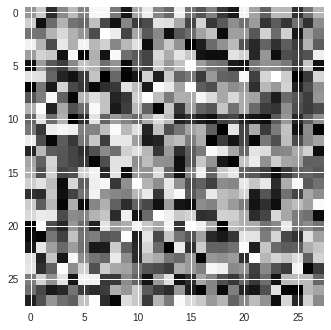

In [40]:
import matplotlib.pyplot as plt

x = torch.rand(
    1, # index in batch
    1, # channel
    28, # height
    28, # width
)
print('given this random image')
plt.imshow(x[0][0], 'gray')
classifier = DigitClassifier()
output = classifier(x)
print('output: ', output)
print('the classified digit: ', output.max(1, keepdim=True)[1])

可以看到 classifier 这个神经网络的实例就是一个函数。它的做用就是把 28 * 28 的灰度图像映射为 0 到 9 的数字

本质上就是一个函数，一个复杂一些的函数

利用第一节里的讲过的梯度下降算法。对于 y = f(x) 我们在给定 x 和 y 的情况下，求解出 f 来。

所以我们先要搞一些数据来

actual:  tensor(7)
classified as:  tensor([ 7])


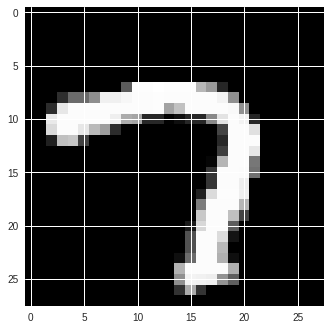

In [88]:
from torchvision import datasets, transforms

transform = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize((0.1307,), (0.3081,))
])

train_loader = torch.utils.data.DataLoader(
  datasets.MNIST('../data', train=True, download=True, transform=transform),
  batch_size=64, shuffle=True, num_workers=1, pin_memory=True)

test_loader = torch.utils.data.DataLoader(
  datasets.MNIST('../data', train=False, transform=transform),
  batch_size=1000, shuffle=True, num_workers=1, pin_memory=True)

# 从训练集里读取一个随机的图片
dataiter = iter(train_loader)
images, labels = dataiter.next()

n = 3 # the 3rd image in the batch
plt.imshow(images[n][0], 'gray')
print('actual: ', labels[n])
classifier.eval() # 设置为 eval 模式
classified = classifier(images).max(1, keepdim=True)[1]
print('classified as: ', classified[n])

我们可以看到，没有经过训练的神经网络还无法对数字进行分类。分类的结果和实际的数字相差很大。

接下来就是要进行训练。首先要定义loss，loss定义对了才能往目标前进

In [89]:
classifier.train() # 设置为训练模式
output = classifier(images)
loss = F.nll_loss(output, labels)
print(loss)

classifier.zero_grad()
loss.backward()

learning_rate = 1e-4
with torch.no_grad():
  for param in classifier.parameters():
    param -= learning_rate * param.grad

tensor(2.3372)


这个更新的过程可以使用现成的optimizer达成同样的目的

多种多样的 optimizer 可以提供比 param -= learning_rate * param.grad 更丰富的选择（不同的更新步长）

In [96]:
import torch.optim as optim

classifier.train() # 设置为训练模式
optimizer = optim.SGD(classifier.parameters(), lr=0.01, momentum=0.5) 
# 这个optimizer和classifier.parameters()形成了绑定关系，调用optimizer就会更新对应的param

output = classifier(images)
loss = F.nll_loss(output, labels)
print(loss)

optimizer.zero_grad() # was classifier.zero_grad()
loss.backward()

learning_rate = 1e-4
optimizer.step() # was with torch.no_grad() ...

tensor(2.2804)


重复这个过程就是训练了

In [100]:
import torch.optim as optim
import time

learning_rate = 1e-4
classifier.train()
optimizer = optim.SGD(classifier.parameters(), lr=0.01, momentum=0.5) 

def train():
  for batch_idx, (images, labels) in enumerate(train_loader):
    output = classifier(images)
    loss = F.nll_loss(output, labels)
    if batch_idx % 100 == 0:
      print(loss)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
%time train()

tensor(0.4624)
tensor(0.3396)
tensor(0.4290)
tensor(0.4415)
tensor(0.1916)
tensor(0.3305)
tensor(0.1884)
tensor(0.1866)
tensor(0.2813)
tensor(0.2009)
CPU times: user 20.1 s, sys: 4.29 s, total: 24.4 s
Wall time: 24.9 s


把执行移动到 GPU 上进行，加快速度

In [101]:
import torch.optim as optim
import time

gpu = torch.device("cuda")
learning_rate = 1e-4
classifier = classifier.to(gpu)
classifier.train()
optimizer = optim.SGD(classifier.parameters(), lr=0.01, momentum=0.5) 

def train():
  for batch_idx, (images, labels) in enumerate(train_loader):
    images, labels = images.to(gpu), labels.to(gpu)
    output = classifier(images)
    loss = F.nll_loss(output, labels)
    if batch_idx % 100 == 0:
      print(loss)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
%time train()

AssertionError: ignored